In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
# from keras.datasets import mnist
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score
from scipy.stats import multivariate_normal as multi_norm

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/appsByWeek-clean.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
df['app'].unique().shape

(206,)

In [4]:
# Clean app names
# for r in range(len(df.index)):
#     if df.iloc[r, 2].find(':') > -1:
#         print df.iloc[r]
#         df.iloc[r, 2] = 'Phone'

In [5]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [6]:
data_dict, unique = convert_to_dict(df)

In [7]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
#             print pid, date
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [8]:
x_train_full, y_train = dict_to_np_array(data_dict)
print x_train_full.shape, y_train.shape

(1911, 206) (1911,)


In [9]:
y_train

array([ 0,  0,  0, ..., 87, 87, 87])

In [10]:
x_train_full.shape

(1911, 206)

In [11]:
x_train = x_train_full.copy()
# for i in np.where(x_train_full.sum(axis=0) > 1)[0][::-1]:
# x_train = np.delete(x_train_full, np.where(x_train_full.sum(axis=0) == 1)[0], axis=1)
# x_train = x_train_full[:, x_train_full.sum(axis=0).argsort()[::-1][:75*75]].reshape((-1, 75*75))

In [12]:
print x_train.shape

(1911, 206)


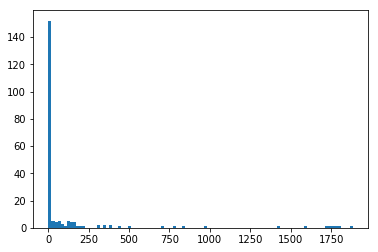

In [13]:
plt.hist(x_train.sum(axis=0), bins=100)
plt.show()

# n = 10  # how many digits we will display
# choice = np.random.choice(range(len(x_train)), n, replace=False)
# plt.figure(figsize=(20, 4))
# for i in range(n):
#     # display original
#     ax = plt.subplot(1, n, i + 1)
#     plt.imshow(x_train[choice[i], :200])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

### Train VAE

In [14]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = x_train.shape[-1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 100
# inter_dim_2 = 250
latent_dim = 16

batch_size = 128
# epochs = 50

In [16]:
# VAE model = encoder + decoder
# build encoder model

dim = original_dim
# layer_dims = [dim]

inputs = Input(shape=(dim,), name='encoder_input')
x = inputs
# while dim // 5 > latent_dim:
#     dim = dim // 5
#     layer_dims.append(dim)
#     x = Dense(dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 206)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          20700       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           1616        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           1616        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [17]:
# layer_dims[1:][::-1]

In [19]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = latent_inputs

# for dim in layer_dims[1:][::-1]:
#     x = Dense(dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_5 (Dense)              (None, 206)               20806     
Total params: 22,506
Trainable params: 22,506
Non-trainable params: 0
_________________________________________________________________


In [20]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [21]:
reconstruction_loss = categorical_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.001, decay=1.0e-5))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 206)               0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  23932     
_________________________________________________________________
decoder (Model)              (None, 206)               22506     
Total params: 46,438
Trainable params: 46,438
Non-trainable params: 0
_________________________________________________________________


In [22]:
vae.fit(x_train, epochs=1000, batch_size=batch_size)

Epoch 1/1000
1911/1911 [==============================] - 1s 311us/step - loss: 13417.4229
Epoch 2/1000
1911/1911 [==============================] - 0s 41us/step - loss: 11849.5822
Epoch 3/1000
1911/1911 [==============================] - 0s 40us/step - loss: 10011.6103
Epoch 4/1000
1911/1911 [==============================] - 0s 40us/step - loss: 9614.0908
Epoch 5/1000
1911/1911 [==============================] - 0s 41us/step - loss: 9384.5068
Epoch 6/1000
1911/1911 [==============================] - 0s 42us/step - loss: 9157.4058
Epoch 7/1000
1911/1911 [==============================] - 0s 42us/step - loss: 8986.4895
Epoch 8/1000
1911/1911 [==============================] - 0s 40us/step - loss: 8895.5490
Epoch 9/1000
1911/1911 [==============================] - 0s 44us/step - loss: 8810.2176
Epoch 10/1000
1911/1911 [==============================] - 0s 47us/step - loss: 8736.9306
Epoch 11/1000
1911/1911 [==============================] - 0s 53us/step - loss: 8658.2392
Epoch 12/1000
1

KeyboardInterrupt: 

In [25]:
# np.save('encoder-bluetoothByWeek.npy', encoder.get_weights())
# np.save('decoder-bluetoothByWeek.npy', decoder.get_weights())

In [24]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

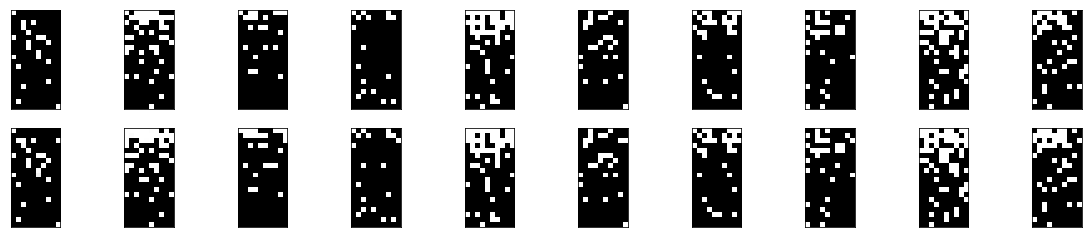

In [25]:
n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_train)), n, replace=False)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

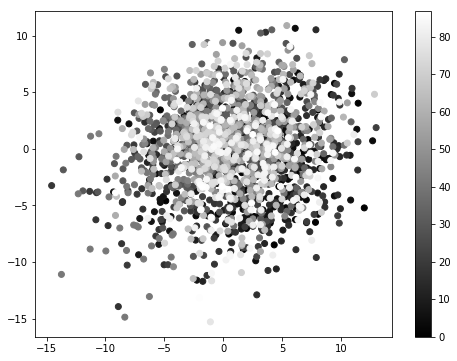

In [26]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [27]:
# pair_dist = []
# pair_label = []
# pair_score =[]

# for i in np.arange(x_test_encoded[2].shape[0]):
#     for j in range(i + 1, x_test_encoded[2].shape[0]):
#         d = np.sqrt(np.power(x_test_encoded[2, i] - x_test_encoded[2, j], 2).sum())
#         pair_dist.append(d)
#         pair_score.append(1 / (d + 1.0e-5))
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)

# print roc_auc_score(y_true=pair_label, y_score=pair_score)

In [28]:
# pair_dist = np.array(pair_dist)
# pair_label = np.array(pair_label)

# bins = np.linspace(pair_dist.min(), pair_dist.max(), 100)

# plt.hist(pair_dist[pair_label], bins, alpha=0.5, label='pos')
# plt.hist(pair_dist[pair_label == False], bins, alpha=0.5, label='neg')
# plt.legend(loc='upper right')
# plt.show()

In [29]:
# pair_dist = []
# pair_label = []

# for i in np.arange(x_train.shape[0]):
#     for j in range(i, x_train.shape[0]):
#         d = np.sqrt(np.power(x_train[i] - x_train[j], 2).sum())
#         pair_dist.append(d)
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)
    
# print roc_auc_score(y_true=pair_label, y_score=pair_dist)

In [30]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[ 0.7426416  -0.12773056 -0.7488425   0.8598446  -2.4607792  -2.763582
 -1.1414791   1.73216    -0.7590586  -2.440402    3.026728   -1.4912816
  1.3388287  -2.0471094  -2.8044896   0.6316562   0.8574933  -2.407217
 -1.9545661   0.9868325   0.41743812  0.8381245   0.45762527  2.0526843
  0.25224325 -0.46649727  1.1218117  -2.5883522   1.1843181  -1.9919894
 -2.92074     1.6957086 ]
[4.2714825 3.987217  3.2220218 5.41015   4.1514015 3.2683067 4.5209947
 4.165388  4.7300277 6.257205  3.6209657 3.917407  4.306157  5.1593437
 3.353457  4.648568  3.3242998 3.6573524 3.8680396 4.1047897 5.1172414
 5.1101017 4.8580275 3.5607738 5.4290156 3.928771  4.263306  3.4107301
 4.146998  3.8737469 3.5313926 4.4847994]


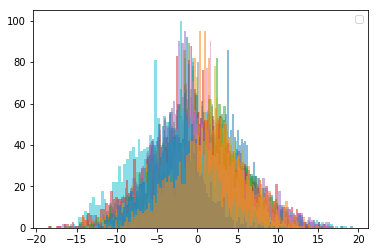

In [31]:
for i in range(len(std)):
    plt.hist(x_test_encoded[0, :, i], bins=100, alpha=0.5)

# plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
# plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

In [32]:
x_test_encoded[0].shape

(1841, 32)

In [33]:
cov = np.cov(x_test_encoded[0].transpose())
print cov

[[18.25547965  2.04565696 -1.98420301 ... -0.42435973 -6.94284737
  -0.79531604]
 [ 2.04565696 15.90654113  2.43836737 ...  4.44951943 -0.81918029
   2.685906  ]
 [-1.98420301  2.43836737 10.38705702 ...  1.88477016 -3.03801592
  -1.53472493]
 ...
 [-0.42435973  4.44951943  1.88477016 ... 15.01405767  3.47677744
   1.92920881]
 [-6.94284737 -0.81918029 -3.03801592 ...  3.47677744 12.47750825
   4.4089432 ]
 [-0.79531604  2.685906   -1.53472493 ...  1.92920881  4.4089432
  20.12437918]]


In [34]:
cov.shape

(32, 32)

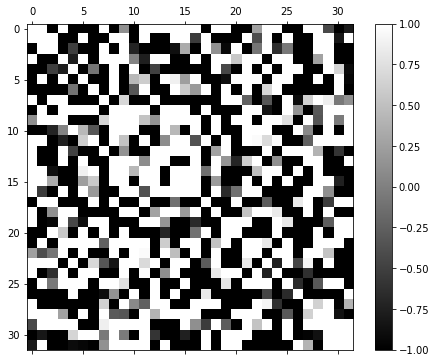

In [35]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cov, vmin=-1, vmax=1)
fig.colorbar(cax)
# ticks = np.arange(0,32,1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(names)
# ax.set_yticklabels(names)
plt.show()

### Apply Generative Probabilistic Model

In [36]:
N_SINGLETONS = 65
N_PAIRS = 5

In [37]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [38]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[ 6 23 30 38 71 28 18 61 82  2  0 36 69  3 35 13 27 11 84 37 51 14 31 44
  7 41 33 62 22 78 67 52  5 68 50 64 49 77 85 45 43 48 65 83 12  9 57 10
 87 20 66 54 15 56 19 60 42  8 39 25 75 58 16 34 74]


In [39]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[1, 4, 17, 21, 24, 26, 29, 32, 40, 46, 47, 53, 55, 59, 63, 70, 72, 73, 76, 79, 80, 81, 86]


In [40]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[17 47 70 73 32]


In [41]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
#     print pid
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
#     print w1, w2
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1)
    vec_list.append(app_vec2)
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
#     print pid
#     print w
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec)
    labels.append(0)

In [42]:
vec_list = np.array(vec_list)
vec_list = vec_list[:, x_train_full.sum(axis=0).argsort()[::-1][:75*75]].reshape((-1, 75*75))

In [43]:
test_encoded_imgs = encoder.predict(vec_list)
test_decoded_imgs = decoder.predict(test_encoded_imgs[2])

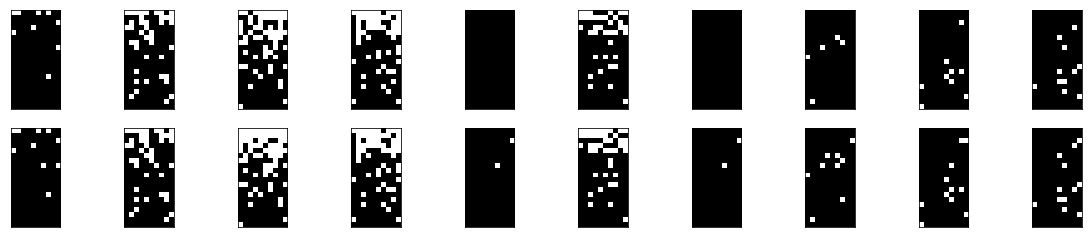

In [44]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(vec_list[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [45]:
points = encoder.predict(np.array(vec_list))[2]

In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(points)

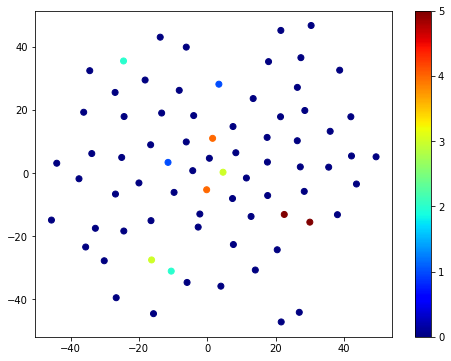

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

In [48]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
std_axis = np.std(points, axis=0)
print std_axis
print sigma

[ 0.4580857  -0.41482434 -1.0833981   1.2238616  -1.8519875  -2.5595756
 -0.6157807   0.94756794 -0.39861092 -2.2467752   4.2204814  -1.3019704
  0.4713055  -1.9856502  -2.9191706   0.664683    1.0228459  -2.7473273
 -1.2496738   0.89999753 -0.3254343   1.747995    1.0389365   2.402427
  0.46984777 -0.66478014  1.0841213  -3.0393615   0.6270559  -1.8659723
 -3.2782087   1.7412173 ]
[3.9357858 4.58495   3.562998  5.361337  4.2629085 3.037452  4.05391
 4.01333   5.1598964 6.1398883 3.3508668 3.7653077 4.579945  4.781282
 2.6954732 4.295056  3.160163  3.7175326 3.5831645 4.3187613 5.631141
 4.949461  4.8580074 3.4038556 4.956287  4.4422374 4.150476  2.9892702
 3.9656749 3.4594142 3.2064264 4.8007584]
4.590642


In [49]:
nu = 0.1

In [50]:
t = (np.ones(std_axis.shape) * nu) / std_axis
# dis_var = np.matmul(t.transpose(), cov)

In [51]:
dis_var = np.diag(t)
print dis_var

[[0.02540789 0.         0.         ... 0.         0.         0.        ]
 [0.         0.02181049 0.         ... 0.         0.         0.        ]
 [0.         0.         0.02806625 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.02890663 0.         0.        ]
 [0.         0.         0.         ... 0.         0.03118737 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02083004]]


In [52]:
cov = np.cov(points.transpose())

In [53]:
cov

array([[15.69974068,  1.14773184, -1.19805002, ..., -1.05958873,
        -4.26012667,  0.23450177],
       [ 1.14773184, 21.30584553,  4.62510333, ...,  5.49235811,
        -1.60083515,  0.79768208],
       [-1.19805002,  4.62510333, 12.86651011, ...,  1.53097973,
        -4.71090949, -1.9195766 ],
       ...,
       [-1.05958873,  5.49235811,  1.53097973, ..., 12.12926968,
         3.04050284, -0.18231083],
       [-4.26012667, -1.60083515, -4.71090949, ...,  3.04050284,
        10.42010757,  4.82436661],
       [ 0.23450177,  0.79768208, -1.9195766 , ..., -0.18231083,
         4.82436661, 23.35872825]])

In [54]:
start = time()

LR_arr = []
LR_idx = []

dist_matrix = np.zeros((points.shape[0], points.shape[0]))
adj_matrix = np.zeros((points.shape[0], points.shape[0]))

for i in np.arange(points.shape[0]):
    for j in np.arange(i + 1, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        
        m = euclidean(midpoint, test_mean)
        d = euclidean(0.5* (points[i] - points[j]), np.zeros(midpoint.shape))
        
        m_prime = m / sigma
        d_prime = d / sigma
        t = nu / sigma
        
        LR = np.power(0.5/t, N_DIM)* np.exp(0.5*(np.power(m_prime,2)+ np.power(d_prime,2)*(2- np.power(t,-2))))
        LR_arr.append(LR)
        dist_matrix[i, j] = LR
        
#         dis = 0.5* (points[i] - points[j])
#         pdf_mid = multi_norm.pdf(midpoint, mean=mean, cov=cov, allow_singular=True)
#         pdf_dis = multi_norm.pdf(dis, mean=np.zeros(dis.shape), cov=dis_var, allow_singular=True)
#         pdf_x_i = multi_norm.pdf(points[i], mean=mean, cov=cov, allow_singular=True)
#         pdf_x_j = multi_norm.pdf(points[j], mean=mean, cov=cov, allow_singular=True)
#         LR = pdf_mid * pdf_dis / (pdf_x_i*pdf_x_j)
#         LR_arr.append(LR)
#         dist_matrix[i, j] = LR
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
            adj_matrix[i, j] = 1
        else:
            LR_idx.append(False)
            adj_matrix[i, j] = 0
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 0.271895 s


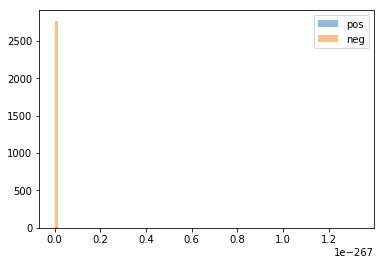

In [55]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [56]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.4994584837545126


In [75]:
dist_matrix = dist_matrix + dist_matrix.transpose()
print dist_matrix

[[0.00000000e+000 4.93595301e+002 0.00000000e+000 ... 5.81601355e-172
  4.17656960e-163 1.69624878e-308]
 [4.93595301e+002 0.00000000e+000 0.00000000e+000 ... 4.57121213e-161
  1.66047308e-152 3.24742988e-295]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.55352044e-082
  5.11304976e-088 2.02158273e-019]
 ...
 [5.81601355e-172 4.57121213e-161 1.55352044e-082 ... 0.00000000e+000
  2.14621988e+002 4.97468585e-020]
 [4.17656960e-163 1.66047308e-152 5.11304976e-088 ... 2.14621988e+002
  0.00000000e+000 4.41784349e-023]
 [1.69624878e-308 3.24742988e-295 2.02158273e-019 ... 4.97468585e-020
  4.41784349e-023 0.00000000e+000]]


In [77]:
adj_matrix = adj_matrix + adj_matrix.transpose()
print adj_matrix

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [93]:
rank = [1,5]

for r in rank:
    hit = 0
    tot = 0.0
    
    for i in np.where(adj_matrix == 1)[0]:
        idx = np.argsort(dist_matrix[i])[::-1]
        if 1 in adj_matrix[i, idx][:r]:
            hit += 1
        tot += 1
    
    print 'rank %d: %f' % (r, hit / tot)

rank 1: 0.700000
rank 5: 1.000000


In [89]:
AP_list = []
for i in np.where(adj_matrix == 1)[0]:
    ap = average_precision_score(y_true=adj_matrix[i], y_score=dist_matrix[i])
    AP_list.append(ap)
print 'mAP: %f' % (np.mean(AP_list))

mAP: 0.816667
